In [67]:

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sqlite3 import Error
from sklearn.ensemble import RandomForestClassifier
import sqlite3
import pickle
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier





In [68]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

In [69]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

/kaggle/input/wikipedia-movie-plots/wiki_movie_plots_deduped.csv


In [70]:
df = pd.read_csv('/kaggle/input/wikipedia-movie-plots/wiki_movie_plots_deduped.csv')
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


# EDA

# 1. to check for no of values

In [71]:
df['Genre'].describe()


count       34886
unique       2265
top       unknown
freq         6083
Name: Genre, dtype: object

In [72]:
# grouping based on genre to see what genre is present in the df
df.groupby(['Genre']).count().sort_values('Title',ascending=False)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Wiki Page,Plot
Genre,,,,,,,
unknown,6083,6083,6083,6083,5400,6083,6083
drama,5964,5964,5964,5964,5841,5964,5964
comedy,4379,4379,4379,4379,4347,4379,4379
horror,1167,1167,1167,1167,1124,1167,1167
action,1098,1098,1098,1098,1087,1098,1098
thriller,966,966,966,966,955,966,966
romance,923,923,923,923,918,923,923
western,865,865,865,865,864,865,865
crime,568,568,568,568,565,568,568


### There are 2265 genres in this df. so narrowing it down to 10 main genres 
### https://www.filmsite.org/genres.html
### Action, adventure, crime, comedy, drama, epic/historical, horror, musical/dance, scifi, war, western, thriller, romance -  is this okay ??????

# Text - preprocessing 

In [73]:
df['Count']=1
df[['Genre','Count']].groupby(['Genre'], as_index=False).count().shape[0]

2265

In [74]:
# harmonization
df['Cleaned_genre'] =df['Genre'] 
df['Cleaned_genre']=df['Cleaned_genre'].str.strip()
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' - ', '|')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' / ', '|')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('/', '|')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' & ', '|')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(', ', '|')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('; ', '|')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('bio-pic', 'biography')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('biopic', 'biography')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('biographical', 'biography')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('biodrama', 'biography')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('bio-drama', 'biography')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('biographic', 'biography')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' \(film genre\)', '')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('animated','animation')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('anime','animation')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('children\'s','children')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('comedey','comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('\[not in citation given\]','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' set 4,000 years ago in the canadian arctic','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('historical','history')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('romantic','romance')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('3-d','animation')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('3d','animation')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('viacom 18 motion pictures','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('sci-fi','science_fiction')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('ttriller','thriller')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('.','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('based on radio serial','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' on the early years of hitler','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('sci fi','science_fiction')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('science fiction','science_fiction')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' (30min)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('16 mm film','short')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('\[140\]','drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('\[144\]','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' for ','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('adventures','adventure')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('kung fu','martial_arts')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('kung-fu','martial_arts')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('martial arts','martial_arts')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('world war ii','war')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('world war i','war')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('biography about montreal canadiens star|maurice richard','biography')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('bholenath df|cinekorn entertainment','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' \(volleyball\)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('spy film','spy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('anthology film','anthology')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('biography fim','biography')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('avant-garde','avant_garde')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('biker film','biker')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('buddy cop','buddy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('buddy film','buddy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('comedy 2-reeler','comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('films','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('film','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('biography of pioneering american photographer eadweard muybridge','biography')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('british-german co-production','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('bruceploitation','martial_arts')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('comedy-drama adaptation of the mordecai richler novel','comedy-drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('df by the mob\|knkspl','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('df','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('movie','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('coming of age','coming_of_age')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('coming-of-age','coming_of_age')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('drama about child soldiers','drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('(( based).+)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('(( co-produced).+)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('(( adapted).+)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('(( about).+)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('musical b','musical')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('animationchildren','animation|children')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' period','period')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('drama loosely','drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' \(aquatics|swimming\)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' \(aquatics|swimming\)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace("yogesh dattatraya gosavi's directorial debut \[9\]",'')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace("war-time","war")
df['Cleaned_genre']=df['Cleaned_genre'].str.replace("wartime","war")
df['Cleaned_genre']=df['Cleaned_genre'].str.replace("ww1","war")
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('unknown','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace("wwii","war")
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('psychological','psycho')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('rom-coms','romance')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('true crime','crime')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('\|007','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('slice of life','slice_of_life')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('computer animation','animation')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('gun fu','martial_arts')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('j-horror','horror')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' \(shogi|chess\)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('afghan war drama','war drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('\|6 separate stories','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' \(30min\)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' (road bicycle racing)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' v-cinema','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('tv miniseries','tv_miniseries')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('\|docudrama','\|documentary|drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' in animation','|animation')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('((adaptation).+)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('((adaptated).+)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('((adapted).+)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('(( on ).+)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('american football','sports')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('dev\|nusrat jahan','sports')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('television miniseries','tv_miniseries')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' \(artistic\)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' \|direct-to-dvd','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('history dram','history drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('martial art','martial_arts')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('psycho thriller,','psycho thriller')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('\|1 girl\|3 suitors','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' \(road bicycle racing\)','')
filterE = df['Cleaned_genre']=="ero"
df.loc[filterE,'Cleaned_genre']="adult"
filterE = df['Cleaned_genre']=="music"
df.loc[filterE,'Cleaned_genre']="musical"
filterE = df['Cleaned_genre']=="-"
df.loc[filterE,'Cleaned_genre']=''
filterE = df['Cleaned_genre']=="comedy–drama"
df.loc[filterE,'Cleaned_genre'] = "comedy|drama"
filterE = df['Cleaned_genre']=="comedy–horror"
df.loc[filterE,'Cleaned_genre'] = "comedy|horror"
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(' ','|')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace(',','|')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('-','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('actionadventure','action|adventure')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('actioncomedy','action|comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('actiondrama','action|drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('actionlove','action|love')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('actionmasala','action|masala')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('actionchildren','action|children')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('fantasychildren\|','fantasy|children')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('fantasycomedy','fantasy|comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('fantasyperiod','fantasy|period')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('cbctv_miniseries','tv_miniseries')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('dramacomedy','drama|comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('dramacomedysocial','drama|comedy|social')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('dramathriller','drama|thriller')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('comedydrama','comedy|drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('dramathriller','drama|thriller')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('comedyhorror','comedy|horror')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('sciencefiction','science_fiction')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('adventurecomedy','adventure|comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('animationdrama','animation|drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('\|\|','|')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('muslim','religious')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('thriler','thriller')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('crimethriller','crime|thriller')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('fantay','fantasy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('actionthriller','action|thriller')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('comedysocial','comedy|social')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('martialarts','martial_arts')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('\|\(children\|poker\|karuta\)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('epichistory','epic|history')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('erotica','adult')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('erotic','adult')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('((\|produced\|).+)','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('chanbara','chambara')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('comedythriller','comedy|thriller')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('biblical','religious')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('biblical','religious')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('colour\|yellow\|productions\|eros\|international','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('\|directtodvd','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('liveaction','live|action')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('melodrama','drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('superheroes','superheroe')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('gangsterthriller','gangster|thriller')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('heistcomedy','comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('heist','action')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('historic','history')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('historydisaster','history|disaster')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('warcomedy','war|comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('westerncomedy','western|comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('ancientcostume','costume')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('computeranimation','animation')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('dramatic','drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('familya','family')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('familya','family')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('dramedy','drama|comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('dramaa','drama')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('famil\|','family')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('superheroe','superhero')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('biogtaphy','biography')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('devotionalbiography','devotional|biography')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('docufiction','documentary|fiction')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('familydrama','family|drama')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('espionage','spy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('supeheroes','superhero')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('romancefiction','romance|fiction')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('horrorthriller','horror|thriller')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('suspensethriller','suspense|thriller')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('musicaliography','musical|biography')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('triller','thriller')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('\|\(fiction\)','|fiction')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('romanceaction','romance|action')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('romancecomedy','romance|comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('romancehorror','romance|horror')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('romcom','romance|comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('rom\|com','romance|comedy')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('satirical','satire')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('science_fictionchildren','science_fiction|children')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('homosexual','adult')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('sexual','adult')

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('mockumentary','documentary')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('periodic','period')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('romanctic','romantic')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('politics','political')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('samurai','martial_arts')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('tv_miniseries','series')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('serial','series')

filterE = df['Cleaned_genre']=="musical–comedy"
df.loc[filterE,'Cleaned_genre'] = "musical|comedy"

filterE = df['Cleaned_genre']=="roman|porno"
df.loc[filterE,'Cleaned_genre'] = "adult"


filterE = df['Cleaned_genre']=="action—masala"
df.loc[filterE,'Cleaned_genre'] = "action|masala"


filterE = df['Cleaned_genre']=="horror–thriller"
df.loc[filterE,'Cleaned_genre'] = "horror|thriller"

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('family','children')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('martial_arts','action')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('horror','thriller')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('war','action')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('adventure','action')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('science_fiction','action')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('western','action')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('western','action')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('noir','black')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('spy','action')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('superhero','action')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('social','')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('suspense','action')


filterE = df['Cleaned_genre']=="drama|romance|adult|children"
df.loc[filterE,'Cleaned_genre'] = "drama|romance|adult"

df['Cleaned_genre']=df['Cleaned_genre'].str.replace('\|–\|','|')
df['Cleaned_genre']=df['Cleaned_genre'].str.strip(to_strip='\|')
df['Cleaned_genre']=df['Cleaned_genre'].str.replace('actionner','action')
df['Cleaned_genre']=df['Cleaned_genre'].str.strip()



In [75]:
moviesGenre = df[['Cleaned_genre','Count']].groupby(['Cleaned_genre']).count()
moviesGenre.to_csv('Cleaned_genre.csv',sep=',')

In [76]:
#after harmonization the genre reduced to 1201 
df[['Cleaned_genre','Count']].groupby(['Cleaned_genre'], as_index=False).count().shape[0]

1201

In [77]:
#Overall look at our genre 
df[['Cleaned_genre','Count']].groupby(['Cleaned_genre'],as_index=False).count().sort_values(['Count'], ascending=False).head(10)


,Cleaned_genre,Count
0,,6204
517,drama,6107
360,comedy,4411
2,action,3790
1113,thriller,2163
965,romance,954
203,animation,601
974,romance|comedy,577
448,crime,573
388,comedy|drama,560


In [78]:
df['GenreSplit']=df['Cleaned_genre'].str.split('|')
df['GenreSplit']= df['GenreSplit'].apply(np.sort).apply(np.unique)

In [79]:
df['GenreSplit']

0                       []
1                       []
2                       []
3                       []
4                       []
               ...        
34881                   []
34882             [comedy]
34883             [comedy]
34884    [comedy, romance]
34885            [romance]
Name: GenreSplit, Length: 34886, dtype: object

In [80]:
# number of movies for each genres
genres_array = np.array([])

for i in range(0,df.shape[0]-1):
    genres_array = np.concatenate((genres_array, df['GenreSplit'][i]))
    
genres_array

array(['', '', '', ..., 'comedy', 'comedy', 'romance'], dtype='<U32')

In [81]:
genres = pd.DataFrame({'Genre':genres_array})

In [82]:
genres.head(10)

,Genre
0,
1,
2,
3,
4,
5,
6,action
7,comedy
8,
9,


In [83]:
# histogram for the genres 
genres['Count']=1
genres[['Genre','Count']].groupby(['Genre'], as_index=False).sum().sort_values(['Count'], ascending=False).head(10)


,Genre,Count
117,drama,9487
86,comedy,7320
0,,6220
4,action,5952
428,thriller,3291
339,romance,2639
95,crime,1607
246,musical,951
16,animation,914
74,children,684


In [84]:
#identifying which genres to be selected
genres=genres[['Genre','Count']].groupby(['Genre'], as_index=False).sum().sort_values(['Count'], ascending=False)

In [85]:
genres = genres[genres['Genre']!='']
genres


,Genre,Count
117,drama,9487
86,comedy,7320
4,action,5952
428,thriller,3291
339,romance,2639
95,crime,1607
246,musical,951
16,animation,914
74,children,684
132,fantasy,542


In [86]:
TotalCountGenres=sum(genres['Count'])
TotalCountGenres

37328

In [87]:
genres['Frequency'] = genres['Count']/TotalCountGenres

In [88]:
genres['CumulativeFrequency'] = genres['Frequency'].cumsum()

In [89]:
genres.head(20)

,Genre,Count,Frequency,CumulativeFrequency
117,drama,9487,0.254152,0.254152
86,comedy,7320,0.196099,0.450252
4,action,5952,0.159451,0.609703
428,thriller,3291,0.088164,0.697868
339,romance,2639,0.070698,0.768565
95,crime,1607,0.043051,0.811616
246,musical,951,0.025477,0.837093
16,animation,914,0.024486,0.861578
74,children,684,0.018324,0.879902
132,fantasy,542,0.014520,0.894422


In [90]:
#Selecting the genres having a cumulative frequency 95.7% and below
np.array(genres[genres['CumulativeFrequency']<=.957]['Genre'])

array(['drama', 'comedy', 'action', 'thriller', 'romance', 'crime',
       'musical', 'animation', 'children', 'fantasy', 'mystery',
       'biography', 'black', 'history', 'short', 'documentary', 'sports',
       'series', 'adult', 'political'], dtype=object)

In [91]:
# a=np.array(genres[genres['CumulativeFrequency']<=.957]['Genre'])
# len(a)

#20 genres

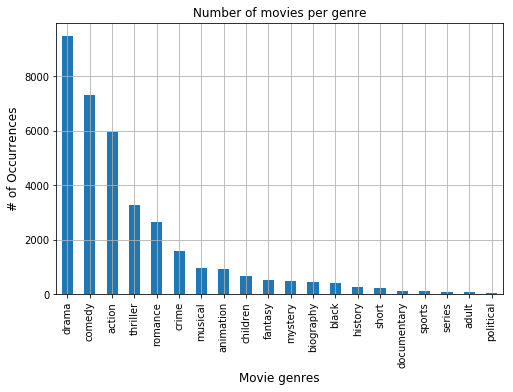

In [92]:
genres[genres['CumulativeFrequency']<=.957][['Genre','Count']].plot(x='Genre', y='Count', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of movies per genre")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Movie genres', fontsize=12)
plt.show()

In [93]:
mainGenres=np.array(genres[genres['CumulativeFrequency']<=.957]['Genre'])
mainGenres

array(['drama', 'comedy', 'action', 'thriller', 'romance', 'crime',
       'musical', 'animation', 'children', 'fantasy', 'mystery',
       'biography', 'black', 'history', 'short', 'documentary', 'sports',
       'series', 'adult', 'political'], dtype=object)

In [94]:
arr1=np.array(['adult', 'romance', 'drama','and'])
arr1[np.in1d(arr1,mainGenres)] # genres not in the mainGenres array will be deleted


array(['adult', 'romance', 'drama'], dtype='<U7')

In [95]:
df['GenreSplit'][10:12].apply(lambda x: x[np.in1d(x,mainGenres)])

10                   [short]
11    [action, crime, short]
Name: GenreSplit, dtype: object

In [96]:
df['GenreSplitMain'] = df['GenreSplit'].apply(lambda x: x[np.in1d(x,mainGenres)])

In [97]:
df[['GenreSplitMain','GenreSplit','Genre']][200:220]

,GenreSplitMain,GenreSplit,Genre
200,[drama],[drama],drama
201,[drama],[drama],drama
202,[comedy],[comedy],comedy
203,[drama],[drama],drama
204,[comedy],[comedy],comedy
205,"[comedy, drama]","[comedy, drama]",comedy drama
206,[mystery],[mystery],mystery
207,[drama],[drama],drama
208,[drama],[drama],drama
209,"[comedy, drama]","[comedy, drama]",comedy drama


In [98]:
# cleaning plots
# function for cleaning the plots of the movies
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    #text = re.sub('\W', ' ', text)
    #text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [99]:
list(df['Plot'][10:12].apply(clean_text))

['the rarebit fiend gorges on welsh rarebit at a restaurant. when he leaves, he begins to get dizzy as he starts to hallucinate. he desperately tries to hang onto a lamppost as the world spins all around him. a man helps him get home. he falls into bed and begins having more hallucinatory dreams. during a dream sequence, the furniture begins moving around the room. imps emerge from a floating welsh rarebit container and begin poking his head as he sleeps. his bed then begins dancing and spinning wildly around the room before flying out the window with the fiend in it. the bed floats across the city as the fiend floats up and off the bed. he hangs off the back and eventually gets caught on a weathervane atop a steeple. his bedclothes tear and he falls from the sky, crashing through his bedroom ceiling. the fiend awakens from the dream after falling out of his bed.',
 'the film features a train traveling through the rockies and a hold up created by two thugs placing logs on the line. the

In [100]:
df['PlotClean'] = df['Plot'].apply(clean_text)

In [101]:
df[['Plot','PlotClean','GenreSplitMain']][6:12]

,Plot,PlotClean,GenreSplitMain
6,The film opens with two bandits breaking into ...,the film opens with two bandits breaking into ...,[action]
7,The film is about a family who move to the sub...,the film is about a family who move to the sub...,[comedy]
8,The opening scene shows the interior of the ro...,the opening scene shows the interior of the ro...,[]
9,Scenes are introduced using lines of the poem....,scenes are introduced using lines of the poem....,[]
10,The Rarebit Fiend gorges on Welsh rarebit at a...,the rarebit fiend gorges on welsh rarebit at a...,[short]
11,The film features a train traveling through th...,the film features a train traveling through th...,"[action, crime, short]"


In [102]:
len(df['GenreSplitMain'][0])

0

In [103]:
df['GenreSplitMain'][0:5].apply(len)

0    0
1    0
2    0
3    0
4    0
Name: GenreSplitMain, dtype: int64

In [104]:
df['MainGenresCount'] = df['GenreSplitMain'].apply(len)

In [105]:
max(df['MainGenresCount'] )

7

In [106]:
df[df['MainGenresCount']==7]

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,Count,Cleaned_genre,GenreSplit,GenreSplitMain,PlotClean,MainGenresCount
17314,2017,American Made,American,Doug Liman,Doug Liman (director); Gary Spinelli (screenpl...,"biography, action, comedy, crime, drama, histo...",https://en.wikipedia.org/wiki/American_Made_(f...,"In the late 1970s, Barry Seal, a pilot for com...",1,biography|action|comedy|crime|drama|history|th...,"[action, biography, comedy, crime, drama, hist...","[action, biography, comedy, crime, drama, hist...","in the late 1970s, barry seal, a pilot for com...",7


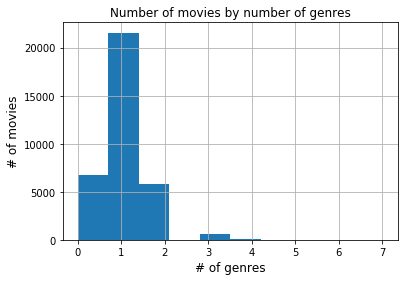

In [107]:
df['MainGenresCount'].hist()

plt.title("Number of movies by number of genres")
plt.ylabel('# of movies', fontsize=12)
plt.xlabel('# of genres', fontsize=12)
plt.show()

### The classifiers 
### Using TF IDF and count vectorizers
### planning on adding DL stuff later on`

In [108]:
df.GenreSplitMain[6:15].apply(lambda x: '-'.join(x)).str.split(pat='-',n=5,expand=True)

,0,1,2
6,action,None,None
7,comedy,None,None
8,,None,None
9,,None,None
10,short,None,None
11,action,crime,short
12,short,None,None
13,biography,None,None
14,comedy,None,None


In [109]:
df.GenreSplitMain[6:15].apply(lambda x: '-'.join(x)).str.get_dummies(sep='-')

,action,biography,comedy,crime,short
6,1,0,0,0,0
7,0,0,1,0,0
8,0,0,0,0,0
9,0,0,0,0,0
10,0,0,0,0,1
11,1,0,0,1,1
12,0,0,0,0,1
13,0,1,0,0,0
14,0,0,1,0,0


In [110]:
df.GenreSplitMain[6:15]

6                   [action]
7                   [comedy]
8                         []
9                         []
10                   [short]
11    [action, crime, short]
12                   [short]
13               [biography]
14                  [comedy]
Name: GenreSplitMain, dtype: object

In [111]:
df.columns

Index(['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast',
       'Genre', 'Wiki Page', 'Plot', 'Count', 'Cleaned_genre', 'GenreSplit',
       'GenreSplitMain', 'PlotClean', 'MainGenresCount'],
      dtype='object')

# Clasification algos 

In [112]:
# the dummy classes
df = pd.concat([df, df.GenreSplitMain.apply(lambda x: '-'.join(x)).str.get_dummies(sep='-')], axis=1)

In [113]:
# the train and the test data set will be built when there is at least one genre for a movie
MoviesTrain, MoviesTest = train_test_split(df[df.Cleaned_genre!=''], random_state=42, test_size=0.10, shuffle=True)

In [114]:
# definition the algorithm for feature extraction
# tfidf = TfidfVectorizer(stop_words ='english', smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')

In [115]:
# building the features
# x_train = tfidf.fit_transform(MoviesTrain.PlotClean) 
# x_test  = tfidf.transform(MoviesTest.PlotClean)
### for test data, the feature extraction will be done through the function transform()
### to make sure there is no features dimensionality mismatch

In [116]:
# print('nrow of the MoviesTrain ={}'. format(MoviesTrain.shape[0]))
# print('nrow of the MoviesTest ={}'. format(MoviesTest.shape[0]))

In [117]:
#x_train.toarray()

In [118]:
y_train = MoviesTrain[MoviesTrain.columns[14:]]
y_test = MoviesTest[MoviesTest.columns[14:]]

In [119]:
#count the number of words in each plot
df['plot_word_count'] = df['Plot'].apply(lambda x: len(str(x).split(" ")))
df[['Plot','plot_word_count']].apply(max)

Plot               “Prof. Ajoy Mukherjee” and his spouse “Aditi” ...
plot_word_count                                                 6731
dtype: object

In [120]:
MoviesTrain['PlotClean']

6591     the police inspector fonseca is interested in ...
17182    within the lego universe, batman continues to ...
12467    on his ninth birthday, omri receives an old cu...
26173    anu gaekwad (madhu sapre), sheila bardez (padm...
4942     ma and pa kettle have lived in a broken-down r...
                               ...                        
22743    in 2008, a combined task group of people  libe...
5453     in a small indiana town in the mid-1910s, the ...
918      when johnny quinlan loses his job in a drug st...
16156    the film is divided into twenty-six individual...
25647    police inspector jai (govinda) lives a middle-...
Name: PlotClean, Length: 25813, dtype: object

In [121]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each plot.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer_train = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer_train.fit_on_texts(MoviesTrain['PlotClean'].values)
word_index = tokenizer_train.word_index
print('Found %s unique tokens.' % len(word_index))

Found 137426 unique tokens.


In [122]:
x_train = tokenizer_train.texts_to_sequences(MoviesTrain['PlotClean'].values)
x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)

Shape of data tensor: (25813, 250)


In [123]:
tokenizer_test = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer_test.fit_on_texts(MoviesTest['PlotClean'].values)
word_index = tokenizer_test.word_index
print('Found %s unique tokens.' % len(word_index))

Found 45602 unique tokens.


In [124]:
x_test = tokenizer_test.texts_to_sequences(MoviesTest['PlotClean'].values)
x_test = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_test.shape)

Shape of data tensor: (2869, 250)


In [125]:
# X_train_A, X_test_A, Y_train_A, Y_test_A = train_test_split(X,Y_actual, test_size = 0.10, random_state = 42)

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(25813, 250) (25813, 20)
(2869, 250) (2869, 20)


In [126]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=x_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(20, activation='relu'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
Total params: 5,082,420
Trainable params: 5,082,420
Non-trainable params: 0
_________________________________________________________________
None


In [127]:
epochs = 5
batch_size = 64

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 23231 samples, validate on 2582 samples
Epoch 1/5
23231/23231 [==============================] - 151s 6ms/step - loss: 3.6686 - acc: 0.2368 - val_loss: 3.3573 - val_acc: 0.2467
Epoch 2/5
23231/23231 [==============================] - 149s 6ms/step - loss: 3.1569 - acc: 0.2451 - val_loss: 3.0981 - val_acc: 0.2467
Epoch 3/5
23231/23231 [==============================] - 149s 6ms/step - loss: 3.1207 - acc: 0.2479 - val_loss: 3.0933 - val_acc: 0.2467
Epoch 4/5
23231/23231 [==============================] - 149s 6ms/step - loss: 3.0878 - acc: 0.2474 - val_loss: 3.0906 - val_acc: 0.2467
Epoch 5/5
23231/23231 [==============================] - 148s 6ms/step - loss: 3.0846 - acc: 0.2475 - val_loss: 3.1885 - val_acc: 0.2467


In [133]:
accr = model.evaluate(x_train,y_train)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

25813/25813 [==============================] - 111s 4ms/step
Test set
  Loss: 3.135
  Accuracy: 0.247


In [129]:
accr = model.evaluate(x_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2869/2869 [==============================] - 12s 4ms/step
Test set
  Loss: 3.187
  Accuracy: 0.245


# relu seems to work fine in a way 

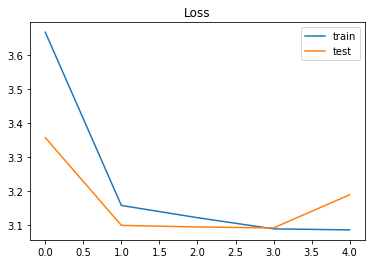

In [130]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

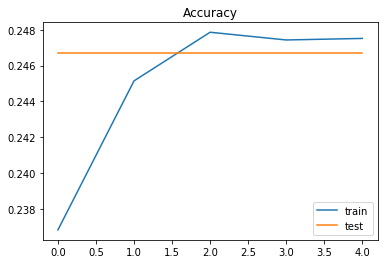

In [131]:

plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [132]:
# new_complaint = ['']
# seq = tokenizer.texts_to_sequences(new_complaint)
# padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
# pred = model.predict(padded)
# labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
# print(pred, labels[np.argmax(pred)])